# Arbres de décision 

decision trees

La vidéo dont est inspiré l'exemple: [Lecture 10 - Decision Trees and Ensemble Methods | Stanford CS229: Machine Learning (Autumn 2018)](https://www.youtube.com/watch?v=wr9gUr-eWdA&list=PLoROMvodv4rMiGQp3WXShtMGgzqpfVfbU&index=11)

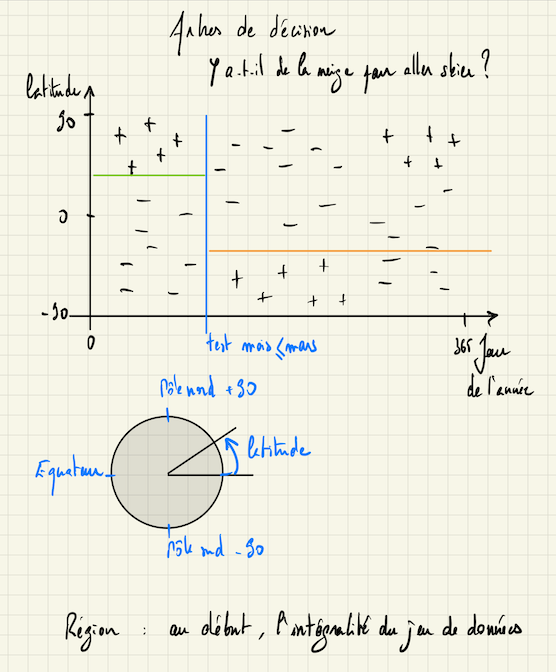

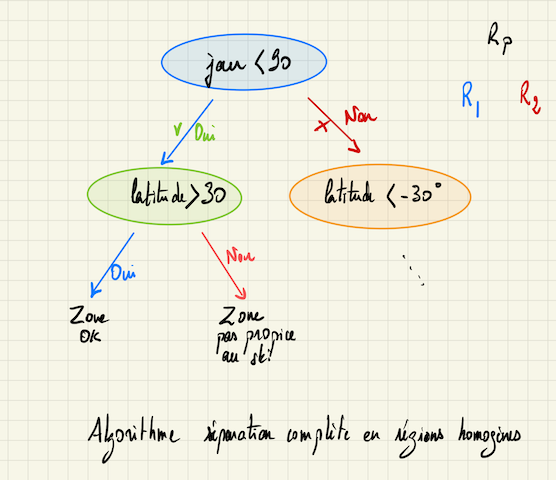

## Création du jeu de données exemple

toy dataset

nord
équateur
sud



In [1]:
pôle_nord = 90
pôle_sud = -90

In [2]:
from collections import namedtuple

Point = namedtuple('Point', 'jour latitude')

In [3]:
import random
random.seed(42)
points = [Point(random.randint(0,364),random.randint(pôle_sud, pôle_nord)) for _ in range(100)]

In [4]:
points[:5]

[Point(jour=327, latitude=-62),
 Point(jour=12, latitude=-20),
 Point(jour=125, latitude=-33),
 Point(jour=71, latitude=-64),
 Point(jour=346, latitude=49)]

Equivalent à:
```py
import random
random.seed(42)
points = []
for _ in range(100):
    x = random.randint(0,364)
    y = random.randint(pôle_sud, pôle_nord)
    points.append(Point(x, y))
```

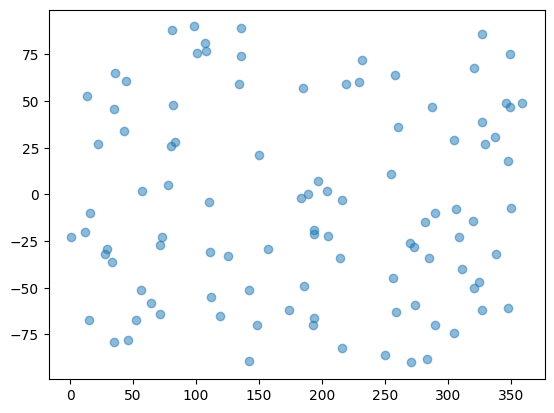

In [5]:
import matplotlib.pyplot as plt
import numpy as np

abscisses = [point.jour for point in points]
ordonnées = [point.latitude for point in points]

plt.scatter(abscisses, ordonnées, alpha=0.5)
plt.show()

hiver austral:
- latitude < -45
- mois juillet, août, septembre $\iff jour \in [[180, 270]]$

hiver boréal:
- latitude > 45
- mois novembre, décembre, janvier, février, mars, avril $\iff jour \in [[305, 365]] ou [[0, 120]]]$

In [6]:
y = []
for point in points:
    if point.latitude<-45 and 180<=point.jour<=270:
        y.append(True)
    elif point.latitude>45 and (0<=point.jour<=120 or 305<=point.jour<=365):
        y.append(True)
    else:
        y.append(False)

y[:5]

[False, False, False, False, True]

In [7]:
points[:5]

[Point(jour=327, latitude=-62),
 Point(jour=12, latitude=-20),
 Point(jour=125, latitude=-33),
 Point(jour=71, latitude=-64),
 Point(jour=346, latitude=49)]

In [8]:
# 1 = bleu
# 0 = rouge
couleurs = list(map(lambda y_i: 'blue' if y_i else 'red', y))

In [9]:
couleurs[:5]

['red', 'red', 'red', 'red', 'blue']

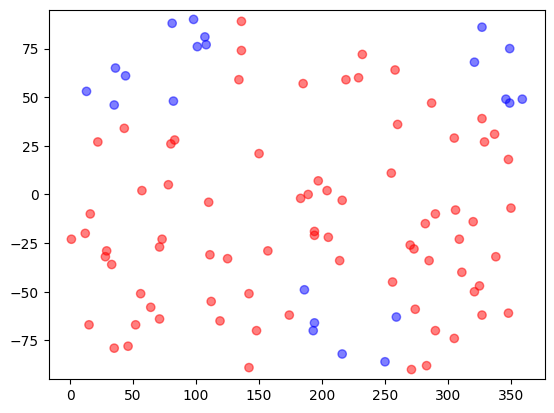

In [10]:
plt.scatter(abscisses, ordonnées, c=couleurs, alpha=0.5)
plt.ylim(-95, 95)
plt.show()

## Représentation graphique des premières séparations

Critère de choix des séparations: avoir le plus de chance d'avoir des points bleus.


### Région condidérée: ensemble des points

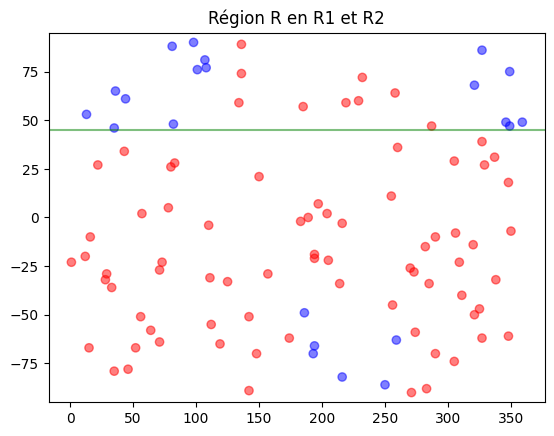

In [11]:
# Premier choix de séparation pour avoir le plus de chance d'avoir des points bleus
# latitude > 45
fig, ax = plt.subplots()

ax.set_title('Région R en R1 et R2')
ax.scatter(abscisses, ordonnées, c=couleurs, alpha=0.5)
ax.axhline(y=45, color='g', alpha=0.5)

plt.ylim(-95, 95)
plt.show()

### Région R1 classée en bleu

In [12]:
import pandas as pd

df = pd.DataFrame({'x_1' : [point.jour for point in points],
                   'x_2' : [point.latitude for point in points],
                   'y': y,
                   'color': couleurs
                 })
df.head()

,x_1,x_2,y,color
0,327,-62,False,red
1,12,-20,False,red
2,125,-33,False,red
3,71,-64,False,red
4,346,49,True,blue


[Sélection de lignes en fonction d'une valeur sur une colonne](https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html)

In [13]:
df_R1= df[df.x_2 > 45].copy()
df_R1.head()

,x_1,x_2,y,color
4,346,49,True,blue
5,44,61,True,blue
9,258,64,False,red
10,13,53,True,blue
11,101,76,True,blue


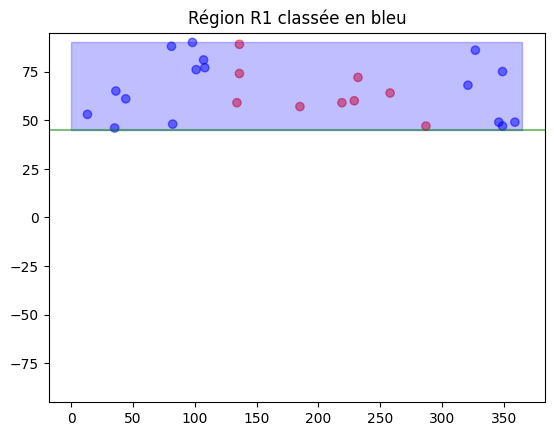

In [14]:
# Région R1 classée en bleu

fig, ax = plt.subplots()

ax.set_title('Région R1 classée en bleu')
ax.scatter(df_R1.x_1, df_R1.x_2, c=df_R1.color, alpha=0.5)
ax.axhline(y=45, color='g', alpha=0.5)
ax.fill_between(x=[-0,365], y1=45, y2=90, color='blue', alpha=.25)
plt.ylim(-95, 95)
plt.show()

### Région R2 classée en rouge

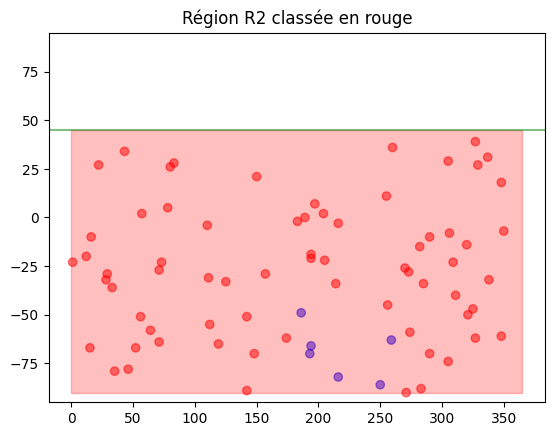

In [15]:
# Région R2 classée en rouge

df_R2= df[df.x_2 <= 45]
fig, ax = plt.subplots()

ax.set_title('Région R2 classée en rouge')
ax.scatter(df_R2.x_1, df_R2.x_2, c=df_R2.color, alpha=0.5)
ax.axhline(y=45, color='g', alpha=0.5)
ax.fill_between(x=[-0,365], y1=-90, y2=45, color='red', alpha=.25)

plt.ylim(-95, 95)
plt.show()

### Arbre de hauteur 1

Algorithme d'un arbre de décision d'une hauteur de 1

In [16]:
# Arbre avec une hauteur = 1
def classification_h1(point):
    if point.latitude > 45:
        return True
    else:
        return False

# Ecriture équivalente
# def classification_h1(point):
#     return point.latitude > 45

In [17]:
# R1
classification_h1(Point(150, 75))

True

In [18]:
# Taux d'erreur dans R1 (point.latitude > 45) zone classée en bleu
9/(10+9+6)

0.36

In [19]:
df_R1.loc[df.y == False].shape[0]/df_R1.shape[0]

0.36

In [20]:
# R2
classification_h1(Point(150, -75))

False

In [21]:
# Taux d'erreur dans R2 (point.latitude <= 45) zone classée en rouge
df_R2.loc[df.y == True].shape[0]/df_R2.shape[0]

0.08

### Arbre de hauteur 2


Algorithme d'un arbre de décision d'une hauteur de 2

On travaille de manière récursive sur chacune des régions R1 et R2 définies

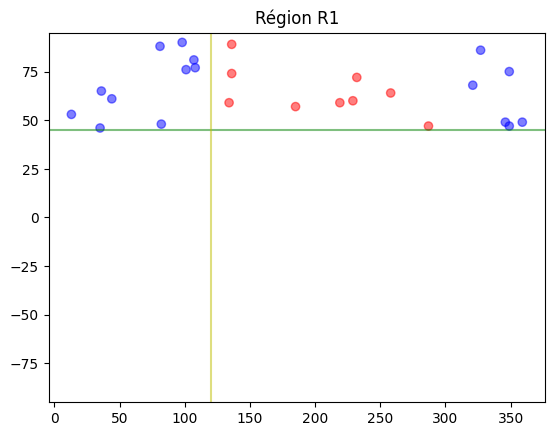

In [22]:
# Second choix de séparation pour avoir le plus de chance d'avoir des points bleus
# jour < 120

fig, ax = plt.subplots()

ax.set_title('Région R1')
ax.scatter(df_R1.x_1, df_R1.x_2, c=df_R1.color, alpha=0.5)
ax.axhline(y=45, color='g', alpha=0.5)
ax.axvline(x=120, color='y', alpha=0.5)
plt.ylim(-95, 95)
plt.show()

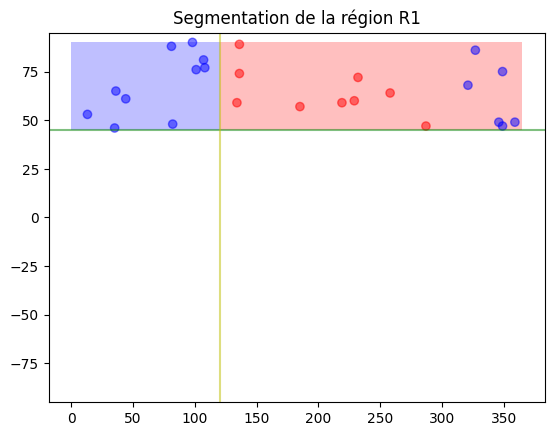

In [23]:
# Second choix de séparation pour avoir le plus de chance d'avoir des points bleus
# jour < 120

fig, ax = plt.subplots()

y1 = [45, 90]

ax.fill_betweenx(y1, 0, 120, facecolor='blue', alpha=0.25)
ax.fill_betweenx(y1, 120, 365, facecolor='red', alpha=0.25)

ax.set_title('Segmentation de la région R1')
ax.scatter(df_R1.x_1, df_R1.x_2, c=df_R1.color, alpha=0.5)
ax.axhline(y=45, color='g', alpha=0.5)
ax.axvline(x=120, color='y', alpha=0.5)
plt.ylim(-95, 95)
plt.show()

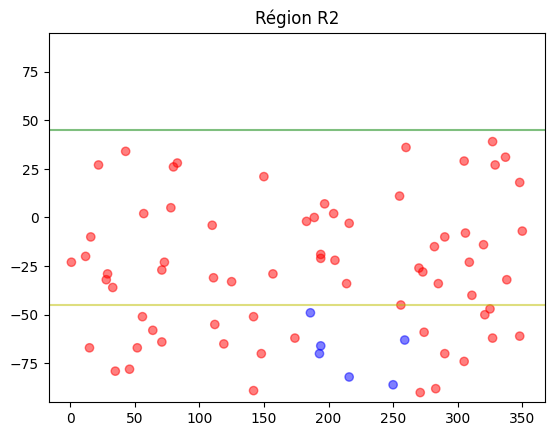

In [24]:
df_R2= df[df.x_2 <= 45]
fig, ax = plt.subplots()

ax.set_title('Région R2')
ax.scatter(df_R2.x_1, df_R2.x_2, c=df_R2.color, alpha=0.5)
ax.axhline(y=45, color='g', alpha=0.5)
ax.axhline(y=-45, color='y', alpha=0.5)
plt.ylim(-95, 95)
plt.show()

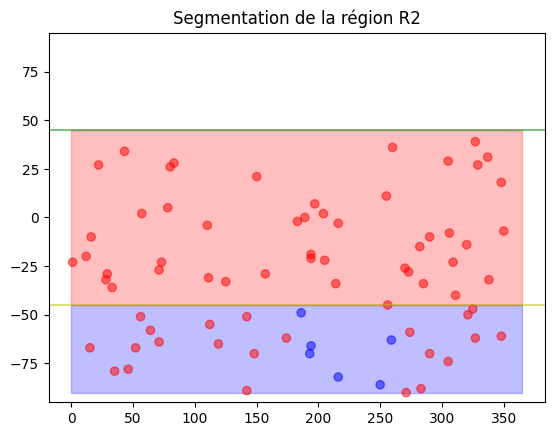

In [25]:
df_R2= df[df.x_2 <= 45]
fig, ax = plt.subplots()

ax.fill_between(x=[0,365], y1=-90, y2=-45, color='blue', alpha=.25)
ax.fill_between(x=[0,365], y1=-45, y2=45, color='red', alpha=.25)


ax.set_title('Segmentation de la région R2')
ax.scatter(df_R2.x_1, df_R2.x_2, c=df_R2.color, alpha=0.5)
ax.axhline(y=45, color='g', alpha=0.5)
ax.axhline(y=-45, color='y', alpha=0.5)

plt.ylim(-95, 95)
plt.show()


In [26]:
# Arbre avec une hauteur = 2
def classification_h2(point):
    if point.latitude > 45:
        if point.jour < 120:
            return True
        else:
            return False
    else:  # point.latitude <= 45
        if point.latitude < -45:
            return True
        else:
            return False

In [27]:
classification_h2(Point(150, -75))

True

In [28]:
# Taux d'erreur sur l'ensemble du jeu de données

## Classification avec scikit learn

[Classifieur par arbre de décision](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

[Visualize a Decision Tree](https://mljar.com/blog/visualize-decision-tree/)

In [29]:
from matplotlib import pyplot as plt
#from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
# Fit the classifier with default hyper-parameters
#clf = DecisionTreeClassifier(random_state=1234)
clf = DecisionTreeClassifier(max_depth=2, random_state=1234)
X = points
model = clf.fit(X, y)

In [30]:
text_representation = tree.export_text(clf)
print(text_representation)

|--- feature_1 <= 42.50
|   |--- feature_1 <= -62.50
|   |   |--- class: False
|   |--- feature_1 >  -62.50
|   |   |--- class: False
|--- feature_1 >  42.50
|   |--- feature_0 <= 121.00
|   |   |--- class: True
|   |--- feature_0 >  121.00
|   |   |--- class: False



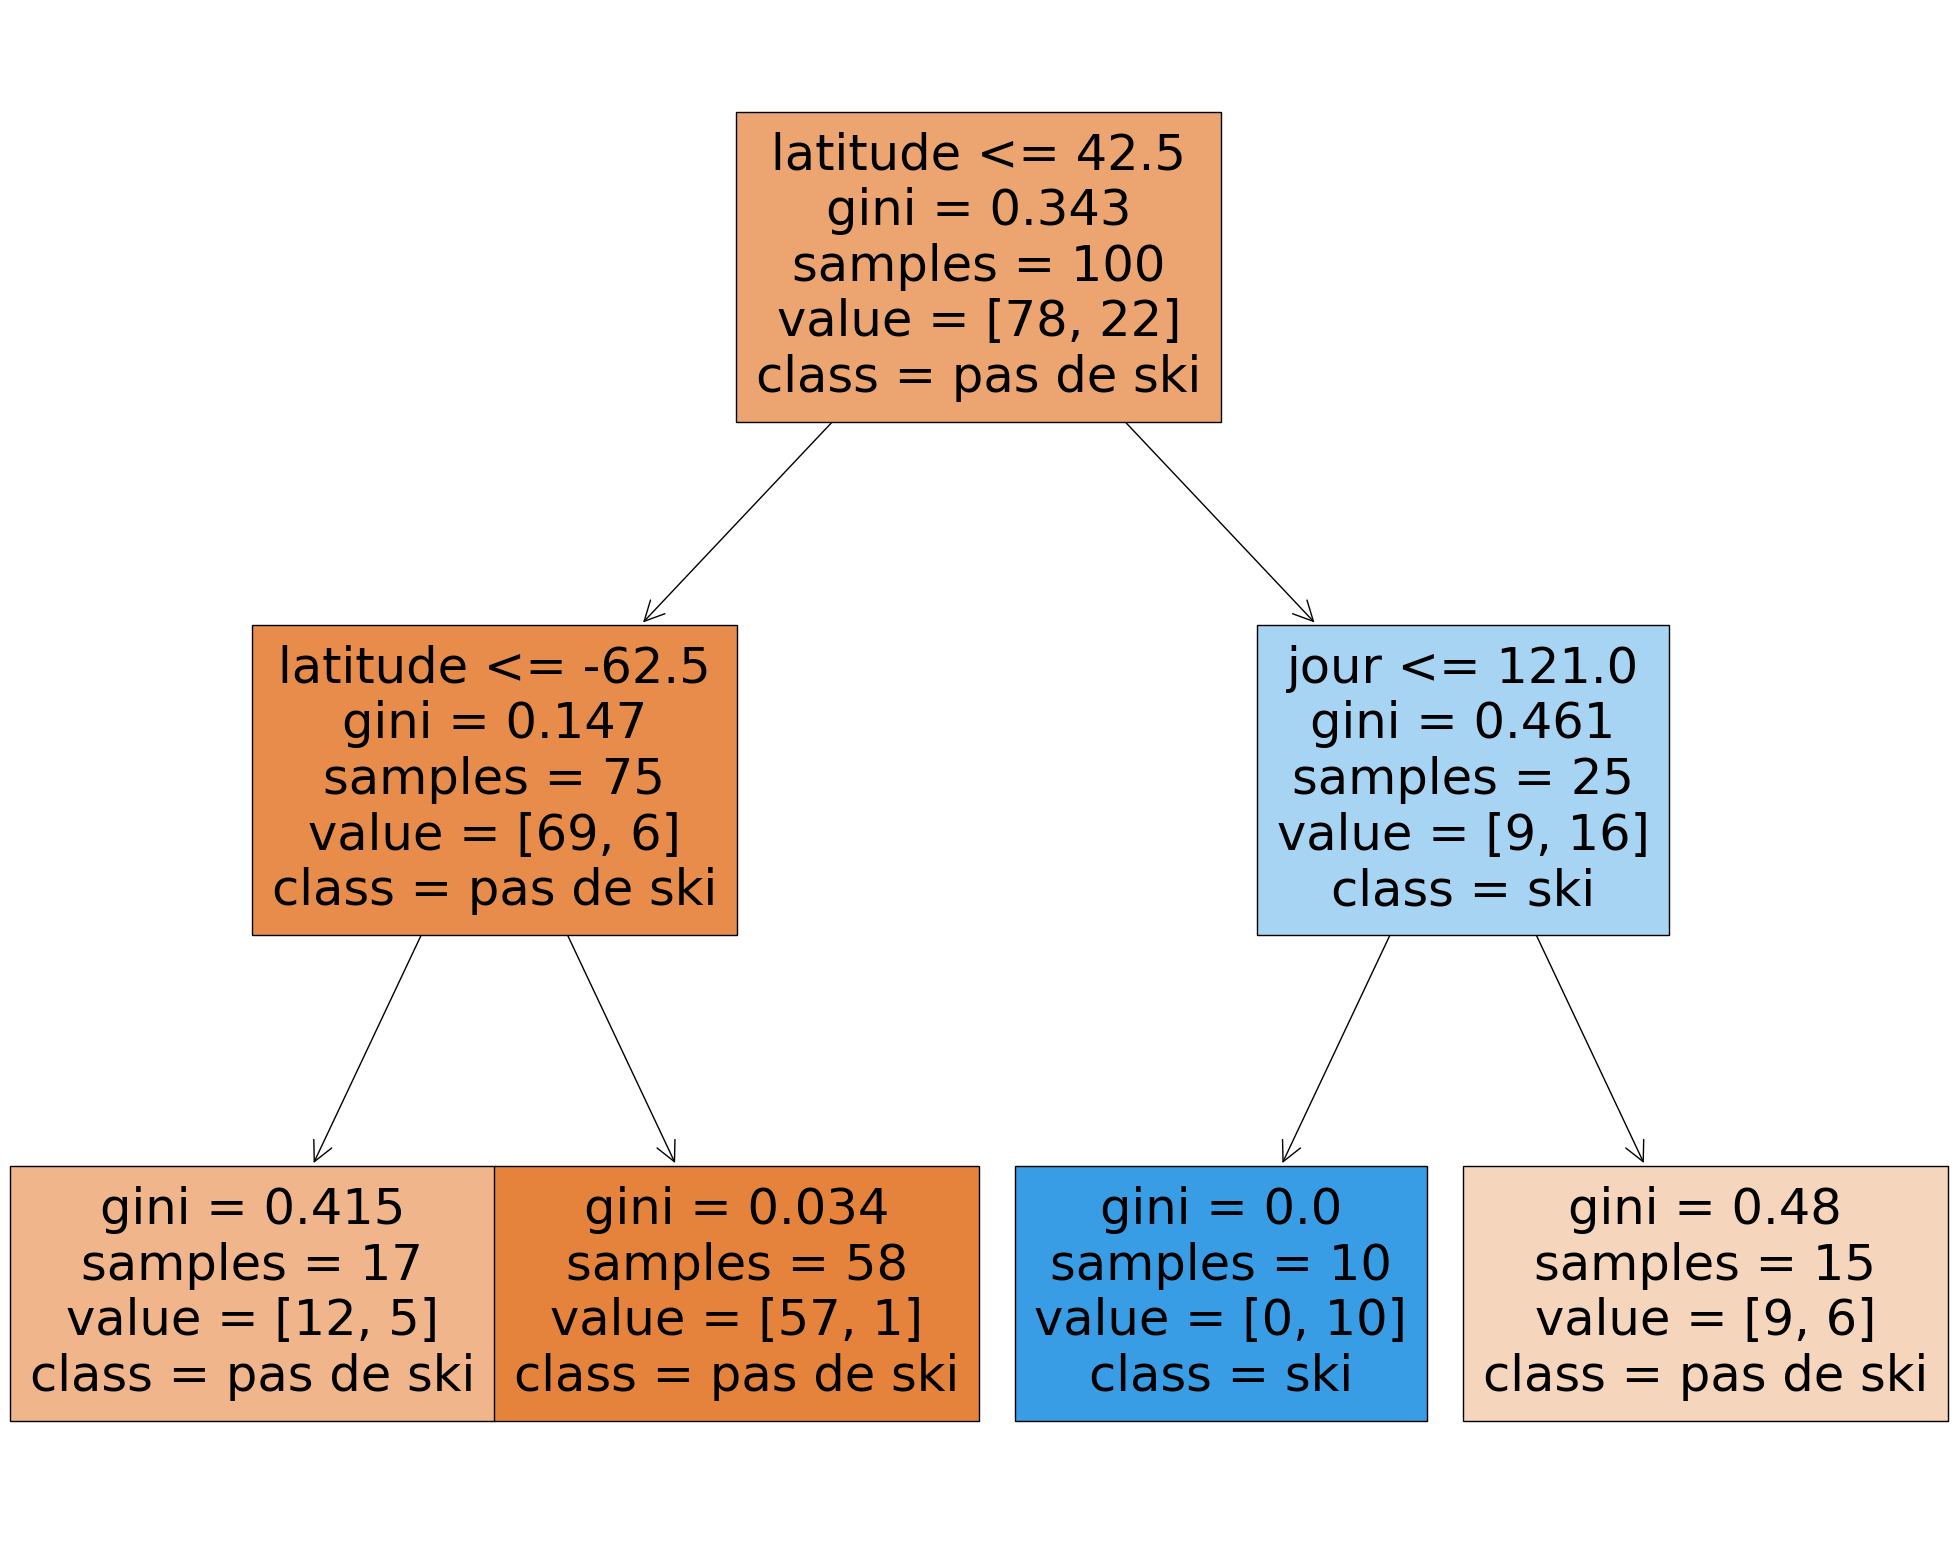

In [31]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=['jour', 'latitude'],  
                   class_names=['pas de ski', 'ski'],
                   filled=True)

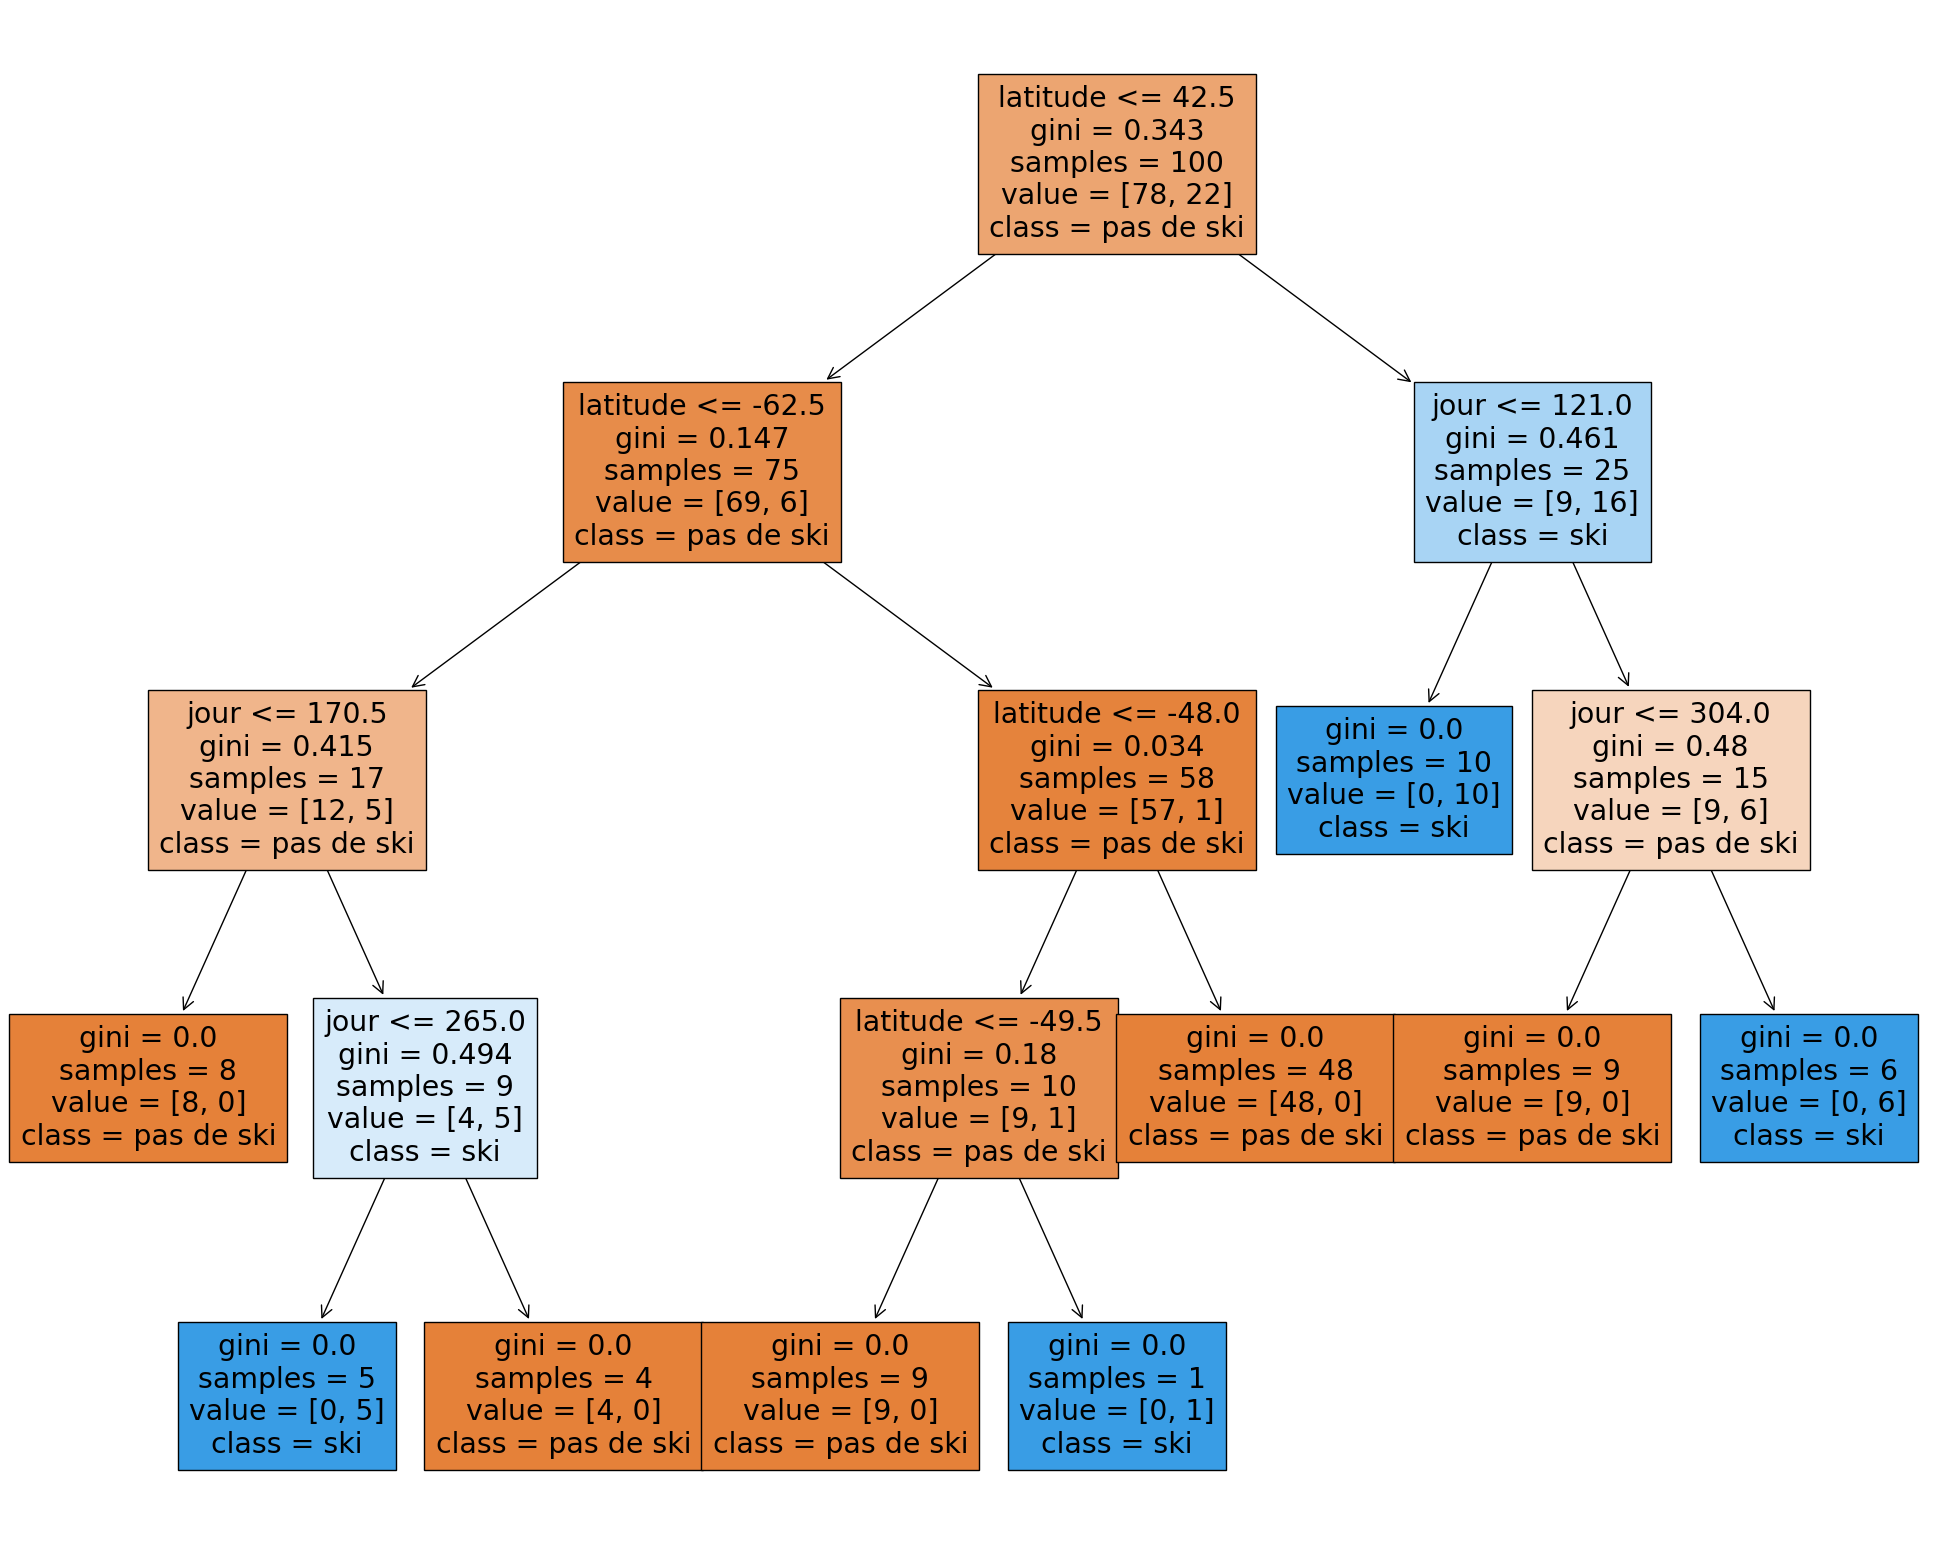

In [32]:
clf = DecisionTreeClassifier(random_state=1234)
X = points
model = clf.fit(X, y)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=['jour', 'latitude'],  
                   class_names=['pas de ski', 'ski'],
                   filled=True)

Est-ce qu'un nouveau point est bien classé par notre algo?

## Application à un vrai jeu de données

Peut-on prédire si un client va acheter une assurance ou pas?

[dataset Caravan](https://islp.readthedocs.io/en/latest/datasets/Caravan.html)

Comparer les résultats avec knn.

[Classifieur par arbre de décision](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [33]:
from ISLP import load_data
from ISLP import confusion_table
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

On laisse les paramètres par défaut de sklearn

In [34]:
caravan = load_data('Caravan')

y = caravan.Purchase.map(lambda x: 1 if x=='Yes' else 0)  # Pour les métriques de scikit learn
X = caravan.drop(columns=['Purchase'])

(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(X,
                            y,
                            test_size=1000,
                            random_state=0)


# La normalisation n'est pas utile pour les arbres de décision

classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train, y_train)

y_test_pred = classifier.predict(X_test)
confusion_table(y_test_pred, y_test)


Truth,0,1
Predicted,,
0,869,54
1,64,13


Score de notre métrique: tp/(tp+fp)

In [35]:
13/(13+64)

0.16883116883116883

16,9%: donc mieux que knn où l'on plafonnait à 15,8%

On peut ensuite faire une exploration des hyperparamètres pour essayer d'améliorer ce résultat.